In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [2]:
filepath = "/kaggle/input/playground-series-s3e25/train.csv"

dataset = pd.read_csv(filepath)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [4]:
y = dataset.pop('Hardness')
x = dataset

### Check dataset

In [5]:
x.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481


In [6]:
y.head()

0    6.0
1    6.5
2    2.5
3    6.0
4    6.0
Name: Hardness, dtype: float64

In [7]:
y.describe()

count    10407.000000
mean         4.647126
std          1.680525
min          1.000000
25%          3.000000
50%          5.500000
75%          6.000000
max         10.000000
Name: Hardness, dtype: float64

<BarContainer object of 10407 artists>

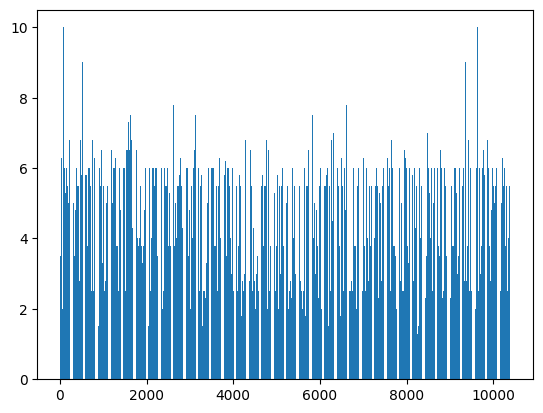

In [8]:
plt.bar(y.index, y)

### Create DNN model

In [9]:
input_shape = x.shape
print(input_shape)

(10407, 12)


try with for loop

In [10]:
def dense_block(width):
    def apply(dx):
        dx = layers.Dense(width, activation='relu')(dx)
        return dx
    return apply

def get_dense_network():
    input_shape = x.shape
    #widths = [130, 64, 32, 16, 8, 4, 2, 1]
    
    # define widths of dense layers
    widths_array = np.arange(10, 0, -1)
    widths = [2**x for x in widths_array]
    
    input_layer = layers.Input(input_shape[1])
    
    dx = layers.Dense(widths[0], activation='relu')(input_layer)
    
    skips = [dx]
    
    # Upblock
    for width in widths:
        if width != widths[0]:
            dx = dense_block(width)(dx)
        
    output_layer = layers.Dense(1, activation='linear')(dx)
    return tf.keras.Model(inputs=input_layer, outputs=output_layer)

DNN_model = get_dense_network()

loss_function = tf.keras.losses.MeanAbsoluteError()
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
DNN_model.compile(loss = loss_function, optimizer=optimiser, metrics=['mae'])

In [11]:
DNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 1024)              13312     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080  

### Test dataset

In [12]:
DNN_model.fit(x, y, epochs=50)

Epoch 1/50
326/326 [==============================] - 9s 4ms/step - loss: 4.4855 - mae: 4.4855
Epoch 2/50
326/326 [==============================] - 1s 5ms/step - loss: 4.1590 - mae: 4.1590
Epoch 3/50
326/326 [==============================] - 1s 4ms/step - loss: 3.8330 - mae: 3.8330
Epoch 4/50
326/326 [==============================] - 1s 4ms/step - loss: 3.5071 - mae: 3.5071
Epoch 5/50
326/326 [==============================] - 1s 4ms/step - loss: 3.1841 - mae: 3.1841
Epoch 6/50
326/326 [==============================] - 1s 5ms/step - loss: 2.8778 - mae: 2.8778
Epoch 7/50
326/326 [==============================] - 1s 4ms/step - loss: 2.5989 - mae: 2.5989
Epoch 8/50
326/326 [==============================] - 1s 4ms/step - loss: 2.3548 - mae: 2.3548
Epoch 9/50
326/326 [==============================] - 1s 4ms/step - loss: 2.1811 - mae: 2.1811
Epoch 10/50
326/326 [==============================] - 1s 4ms/step - loss: 2.0524 - mae: 2.0524
Epoch 11/50
326/326 [============================

### Test submission

In [13]:
test_dataset = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")

In [14]:
test_dataset.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456


In [15]:
predictions = DNN_model.predict(test_dataset)

217/217 [==============================] - 0s 2ms/step


Create subbmission flie

In [16]:
submission = pd.DataFrame()
submission['id'] = test_dataset['id']
submission['Hardness'] = predictions

In [17]:
submission.head()

,id,Hardness
0,10407,5.498637
1,10408,5.498637
2,10409,5.498637
3,10410,5.498637
4,10411,5.498637


In [18]:
submission.describe()

,id,Hardness
count,6939.000000,6939.000000
mean,13876.000000,5.498637
std,2003.261091,0.000000
min,10407.000000,5.498637
25%,12141.500000,5.498637
50%,13876.000000,5.498637
75%,15610.500000,5.498637
max,17345.000000,5.498637


In [19]:
submission.to_csv('/kaggle/working/submission.csv',index=False,header=True)